In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob

sys.path.insert(0, "../hcr-ff/")
from plot_utils import *
from genome_utils import *

In [2]:
def check_overlap(interval, array):
    height = array.shape[0]
    intervals = np.stack([np.tile(interval,(height,1)), array],axis=0)
    anchor =  (intervals[0,:,0] < intervals[1,:,0]).astype(int)
    return intervals[1-anchor,np.arange(height),1] > intervals[anchor,np.arange(height),0]


In [3]:
EPR1_fn = '../data/ERP29_rep1detailed.txt'
ERR2_fn = '../data/ERP29_rep2detailed.txt'

fn_list = [EPR1_fn,ERR2_fn]

exp_ids = ['EPR1','EPR2']

fullinfo= [("ERP29",1), ("ERP29",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [4]:
gff = pd.read_table('../data/ATXN_locus.gff')

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,transcriptID,geneID
0,ENST00000335007.10,chr12,-,110719679,110742891,110721075,110742707,7,"110719679,110722134,110722471,110724659,110730...","110721165,110722269,110722695,110724764,110730...",P36873,uc001tru.5,PPP1CC
1,ENST00000545036.5,chr12,+,110846959,110907534,110853515,110907476,11,"110846959,110853404,110858585,110873841,110879...","110847105,110853574,110858775,110873961,110880...",Q8NA47,uc010sye.3,CCDC63
2,ENST00000228841.13,chr12,-,110910818,110920600,110911076,110920529,7,"110910818,110913095,110913245,110914185,110915...","110911175,110913144,110913324,110914290,110915...",Q6IB42,uc001try.6,MYL2
3,ENST00000261726.11,chr12,+,111034164,111350554,111034177,111348325,22,"111034164,111214199,111217889,111263760,111291...","111034240,111214310,111217937,111263839,111291...",O14529,uc001tsa.5,CUX2
4,ENST00000361483.4,chr12,-,111360650,111369121,111362677,111365566,4,"111360650,111365563,111366112,111368911","111363463,111365651,111366257,111369121",Q8N4B1,uc021rdy.1,PHETA1
5,ENST00000377617.8,chr12,-,111452267,111599676,111452811,111599514,25,"111452267,111453676,111456028,111457213,111464...","111452840,111453845,111456256,111457359,111464...",Q99700,uc001tsj.4,ATXN2
6,ENST00000419234.9,chr12,-,111642145,111685956,111644198,111685792,12,"111642145,111649938,111655565,111658735,111659...","111644562,111650042,111655655,111658845,111659...",Q7Z569,uc001tsn.5,BRAP
7,ENST00000455480.6,chr12,+,111686075,111757094,111692709,111756473,22,"111686075,111692696,111702161,111705737,111709...","111686239,111692896,111702310,111705932,111709...",Q6JQN1,uc009zvx.4,ACAD10
8,ENST00000261733.7,chr12,+,111766932,111817532,111766982,111809575,13,"111766932,111781917,111783157,111785266,111789...","111767096,111782022,111783298,111785346,111789...",P05091,uc001tst.5,ALDH2
9,ENST00000551404.6,chr12,+,111842625,111893161,111842733,111893061,14,"111842625,111865249,111866155,111867571,111868...","111842769,111865323,111866231,111867669,111868...",Q8IW41,uc001tta.5,MAPKAPK5


In [6]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("CTRL")) &\
                           (~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [8]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [9]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end']) for fn in sorted(glob.glob('../data/ERP*__lowresMergedPeaks.bed')) ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ (feat['chr'] == 'chr10') | (feat['chr'] == 'chr11') | \
                               (feat['chr'] == 'chr12') | (feat['chr'] == 'chr5') ,
                              :] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['EPR1','EPR2','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


2
4


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
test_peaks.loc[ test_peaks['exp_id'] == 'EPR1', 'assay' ].unique().item()

'ERP29'

In [11]:
data

,EPR1,EPR2,cutsite
Coordinates,,,
chr12:110726151-110726172:-,-0.732368,-0.136831,110726154
chr12:110726157-110726178:-,0.327377,0.200304,110726160
chr12:110726178-110726199:-,-0.012793,-0.178468,110726181
chr12:110726182-110726203:-,-0.083231,0.228801,110726185
chr12:110726183-110726204:-,0.042415,-0.270355,110726186
chr12:110726209-110726230:-,0.306654,0.307841,110726212
chr12:110726210-110726231:-,0.534082,1.008177,110726213
chr12:110726213-110726234:-,0.219011,-0.188178,110726216
chr12:110726214-110726235:-,-0.333434,-0.132644,110726217


In [12]:
test_peaks

,chr,start,end,exp_id,assay,replicate
0,chr10,100717366,100717866,EPR1,ERP29,1
1,chr11,55993881,55994381,EPR1,ERP29,1
2,chr12,111508526,111509026,EPR1,ERP29,1
3,chr12,111994026,111995026,EPR1,ERP29,1
4,chr12,111995526,111996026,EPR1,ERP29,1
5,chr12,112005026,112006526,EPR1,ERP29,1
6,chr12,112013026,112015026,EPR1,ERP29,1
7,chr10,100768866,100769366,EPR2,ERP29,2
8,chr11,56048881,56049381,EPR2,ERP29,2
9,chr11,56070381,56070881,EPR2,ERP29,2


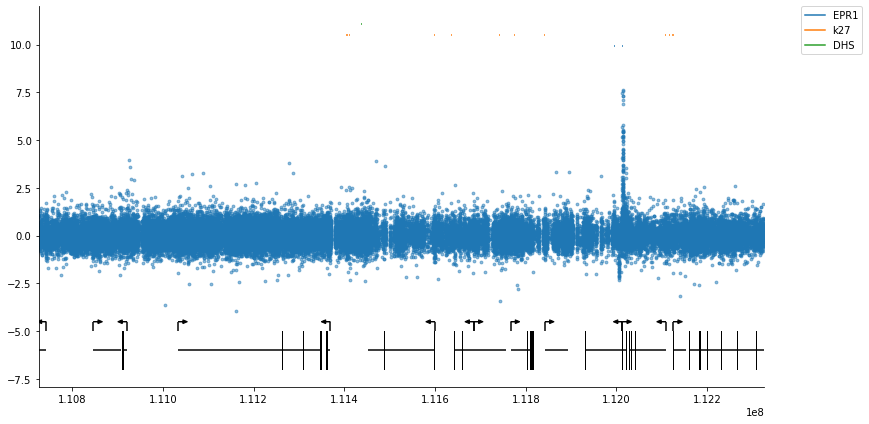

In [13]:
fig_h = plot_hff_cutsites(np.array([[110726026,112325903]]), 
                  data, test_peaks, plot_ids=['EPR1','k27','DHS'], get_chrom='chr12')
draw_genes_from_gff(fig_h[1], gff, promoter_params=[10000,0.2,10000])

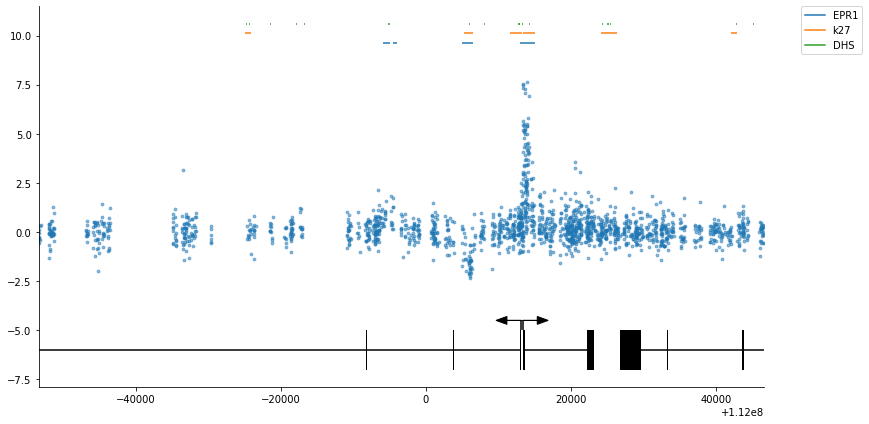

In [14]:
fig_h = plot_hff_cutsites(np.array([[111946626,112046626]]), 
                  data, test_peaks, plot_ids=['EPR1','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[2000,0.4,1500])

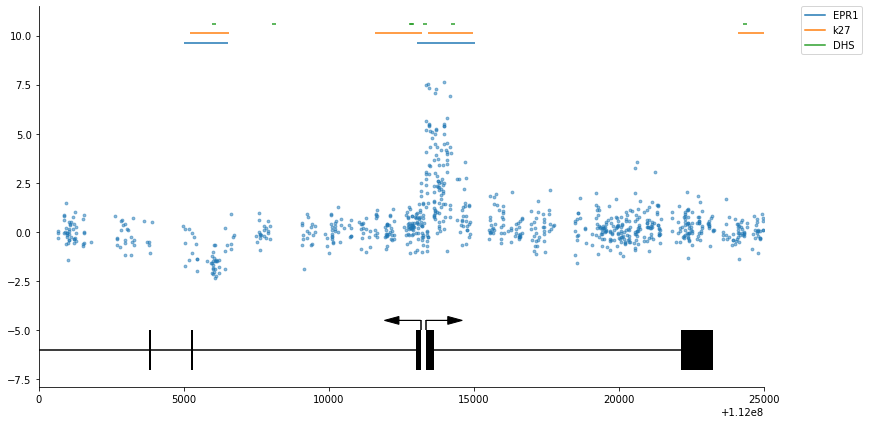

In [15]:
fig_h = plot_hff_cutsites(np.array([[112000000,112025000]]), 
                  data, test_peaks, plot_ids=['EPR1','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[750,0.4,500])

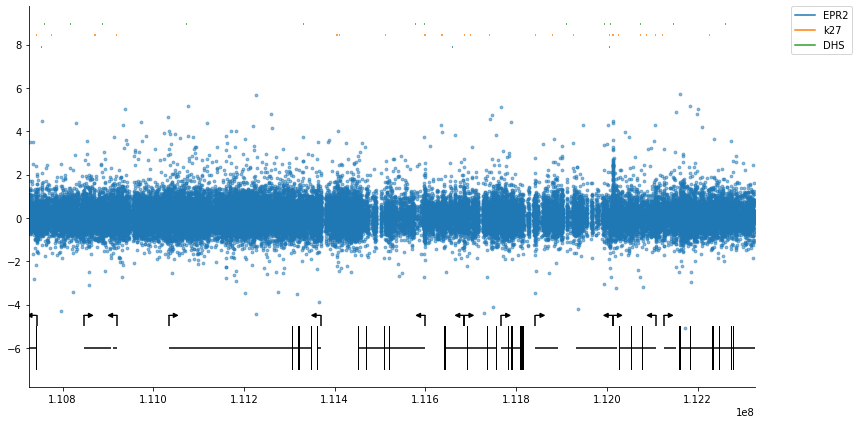

In [16]:
fig_h = plot_hff_cutsites(np.array([[110726026,112325903]]), 
                  data, test_peaks, plot_ids=['EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[10000,0.2,10000])

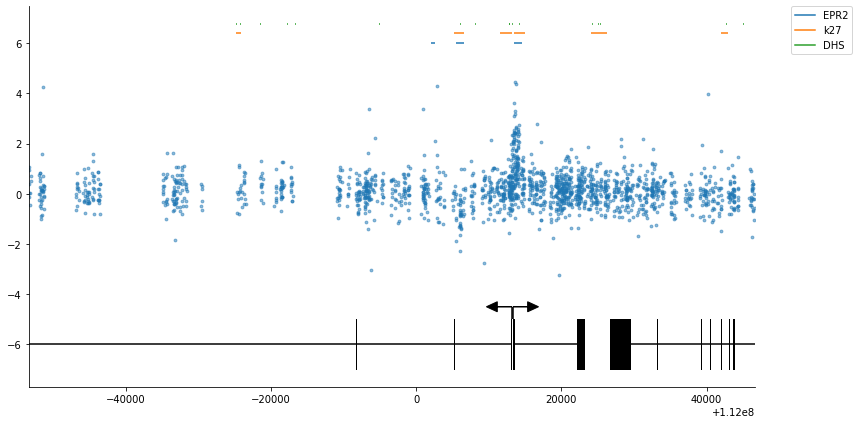

In [17]:
fig_h = plot_hff_cutsites(np.array([[111946626,112046626]]), 
                  data, test_peaks, plot_ids=['EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[2000,0.4,1500])

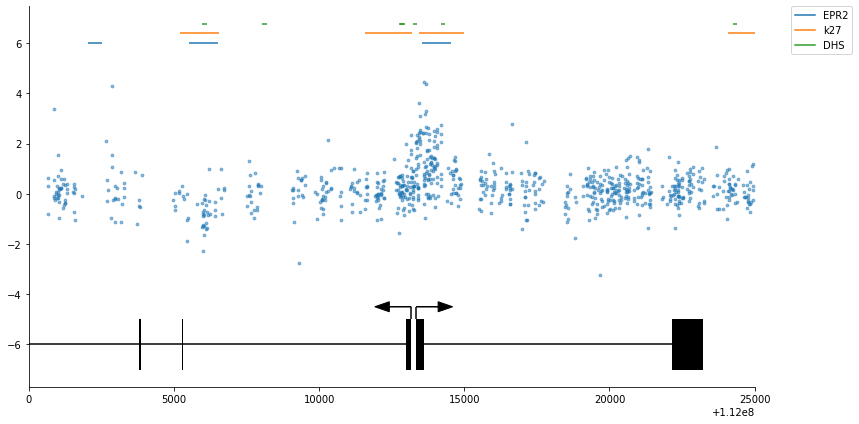

In [18]:
fig_h = plot_hff_cutsites(np.array([[112000000,112025000]]), 
                  data, test_peaks, plot_ids=['EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[750,0.4,500])

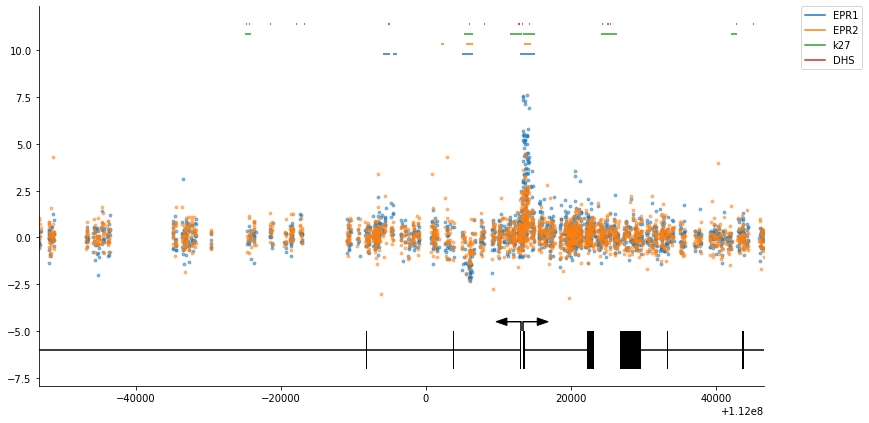

In [19]:
fig_h = plot_hff_cutsites(np.array([[111946626,112046626]]), 
                  data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[2000,0.4,1500])

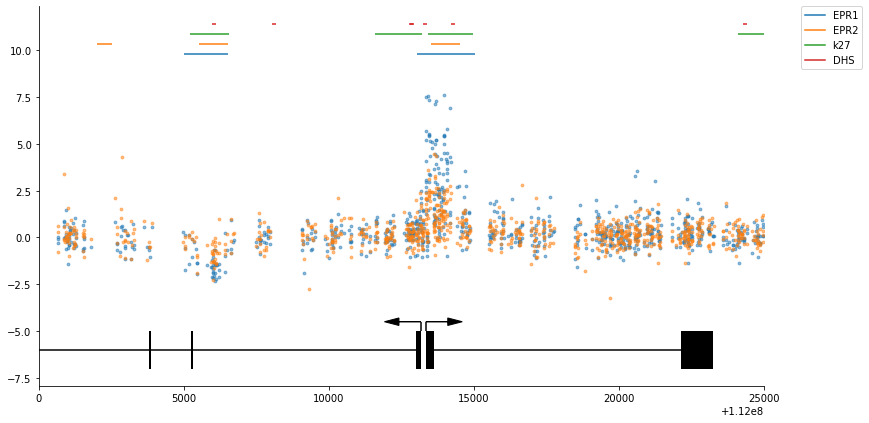

In [20]:
fig_h = plot_hff_cutsites(np.array([[112000000,112025000]]), 
                  data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[750,0.4,500])

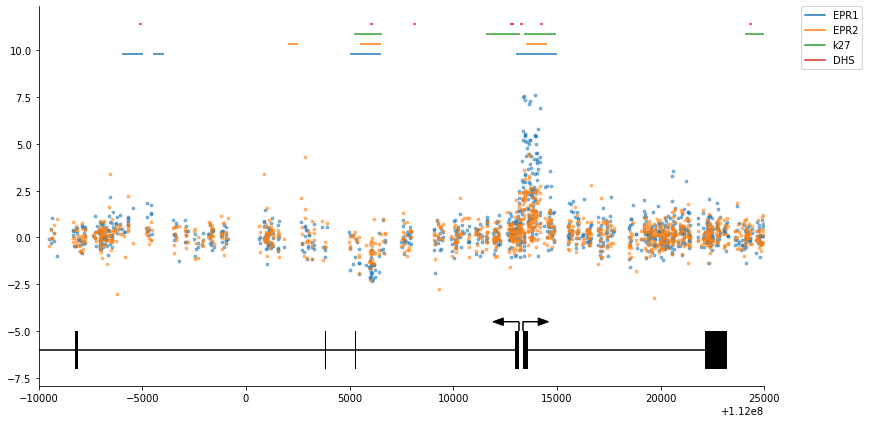

In [21]:
fig_h = plot_hff_cutsites(np.array([[112000000-10000,112025000]]), 
                  data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff, promoter_params=[750,0.4,500])

ERP29
73


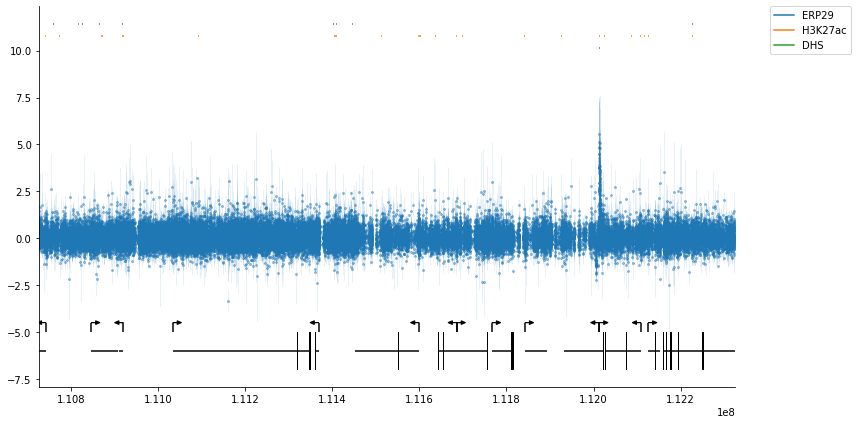

In [22]:
fig_h, ax_h = plot_combined_cutsites(np.array([[110726026,112325903]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[10000,0.2,10000])
fig_h.savefig('ATXN_locus__110726026_112325903__all.pdf')

ERP29
3


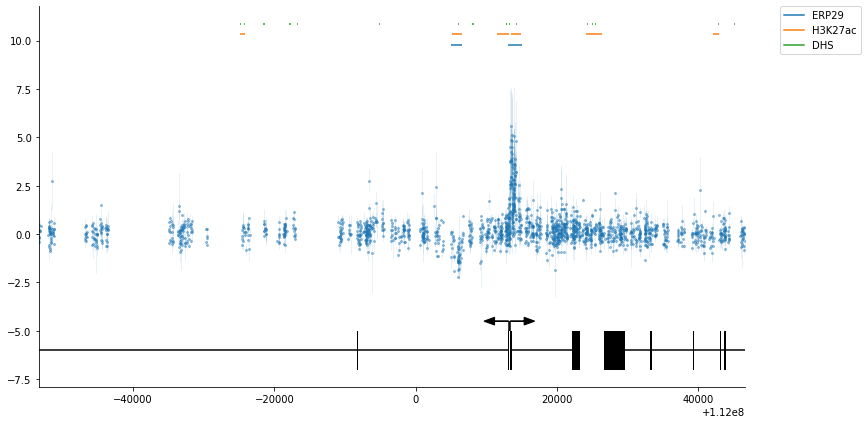

In [23]:
fig_h, ax_h = plot_combined_cutsites(np.array([[111946626,112046626]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[2000,0.4,1500])
fig_h.savefig('ATXN_locus__111946626_112046626__all.pdf')

ERP29
0


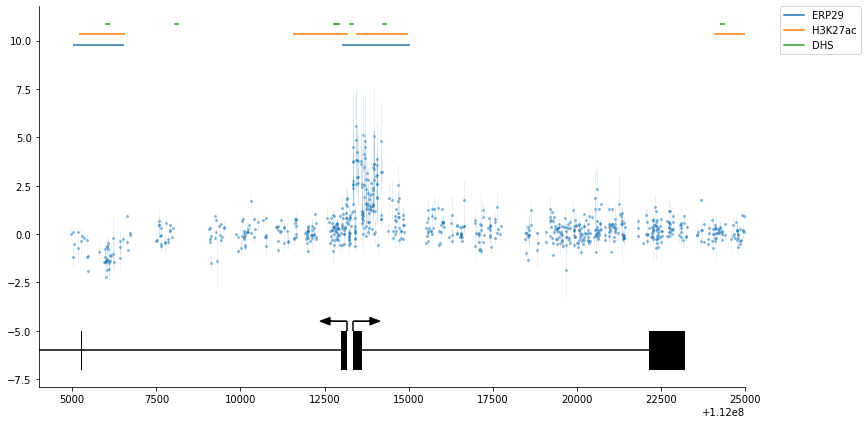

In [24]:
fig_h, ax_h = plot_combined_cutsites(np.array([[112004000,112025000]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[500,0.4,300])
fig_h.savefig('ATXN_locus__112004000_112025000__all.pdf')

ERP29
4


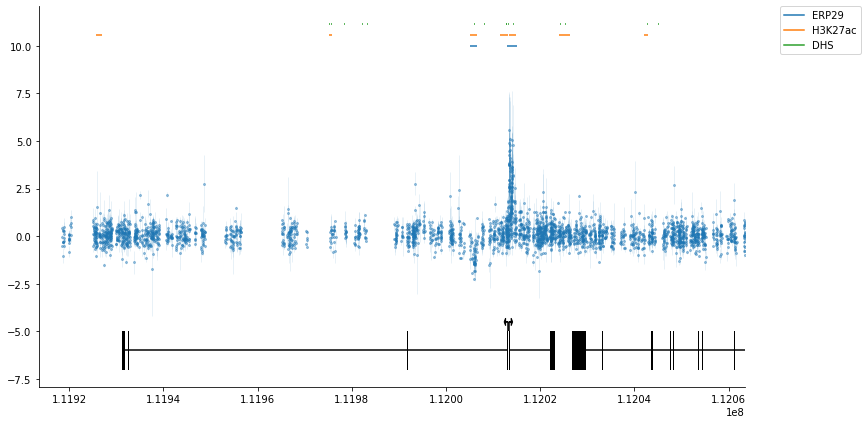

In [31]:
fig_h, ax_h = plot_combined_cutsites(np.array([[111913514,112063514]]), 
          data, test_peaks, plot_ids=['EPR1','EPR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff, promoter_params=[500,0.4,300])
fig_h.savefig('ATXN_locus__111913514_112063514__all.pdf')

# Connection diagram

In [25]:
txn_starts = extract_txn_starts(gff)

In [26]:
all_locus_peaks = get_replicating_peaks(test_peaks)

In [27]:
# ERP29
## rep 1
ERP29_rep1_scores = pd.read_table('../data/ERP29_rep1__lowresPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
ERP29_rep1_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in ERP29_rep1_scores['hdr'] ]

ERP29_rep1_scores['score'] = ERP29_rep1_scores['score'] - ERP29_rep1_scores['score'].median()

## rep 2
ERP29_rep2_scores = pd.read_table('../data/ERP29_rep2__lowresPeaks.bed',header=None,
                                  names=['chr','start','end','hdr','pass','strand'])
ERP29_rep2_scores['score'] = [ np.array(interval.split(',')).astype(float).mean() 
                               for interval in ERP29_rep2_scores['hdr'] ]

ERP29_rep2_scores['score'] = ERP29_rep2_scores['score'] - ERP29_rep2_scores['score'].median()

## combine
ERP29_total_scores = ERP29_rep1_scores.copy()
ERP29_total_scores['pass'] = (ERP29_rep1_scores['pass'] & ERP29_rep2_scores['pass'])
ERP29_total_scores['score'] = (ERP29_rep1_scores['score'] + ERP29_rep2_scores['score']) / 2


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if sys.path[0] == '':


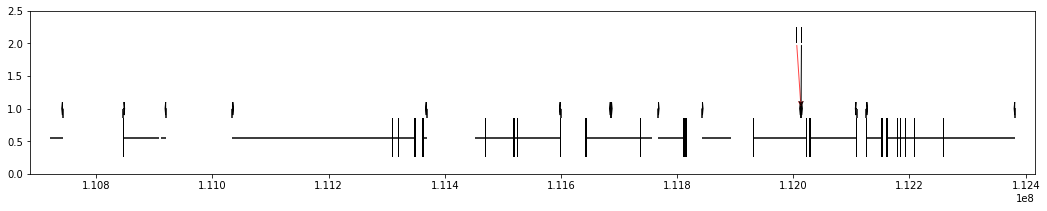

In [28]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ERP29'], y_anchor=2.0, y_target=1.0, score_bed=ERP29_total_scores)

plt.savefig('ATXN_locus__full_locus__connectogram.pdf')

plt.show()

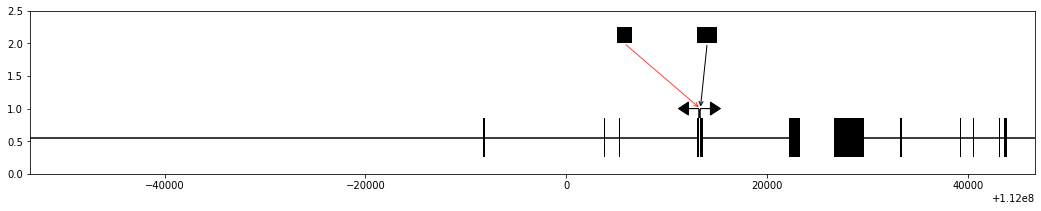

In [29]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [111946626,112046626]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ERP29'], y_anchor=2.0, y_target=1.0, score_bed=ERP29_total_scores)

plt.savefig('ATXN_locus__111946626_112046626__connectogram.pdf')

plt.show()

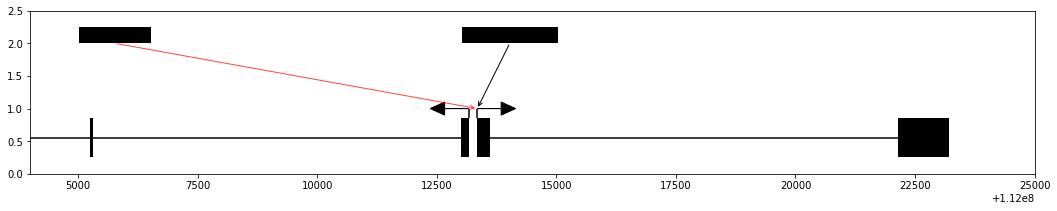

In [30]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [112004000,112025000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,300], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ERP29'], y_anchor=2.0, y_target=1.0, score_bed=ERP29_total_scores)

plt.savefig('ATXN_locus__112004000_112025000__connectogram.pdf')

plt.show()

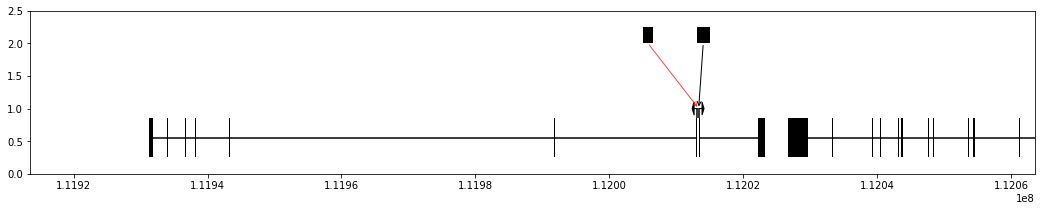

In [32]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [111913514,112063514]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,300], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['ERP29'], y_anchor=2.0, y_target=1.0, score_bed=ERP29_total_scores)

plt.savefig('ATXN_locus__111913514_112063514__connectogram.pdf')

plt.show()